<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Classification with SGD - minibatch - large dataset



# Imports
<hr style = "border:2px solid black" ></hr>

In [49]:
import numpy as np
import os, csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import zlib, time
from random import shuffle
from sklearn.linear_model import SGDClassifier
rcParams['figure.figsize'] = 14, 5
rcParams['font.size'] = 20

# Load the datatest


- Forest Covertype data.
- It has 581,012 instances.



In [2]:
source = '../DATASETS/LARGE_DATASETS/covtype/covtype.data'
sourceFolder = '../DATASETS/LARGE_DATASETS/covtype/'

SEP=','
forest_type = {1:"Spruce/Fir", 2:"Lodgepole Pine", \
               3:"Ponderosa Pine", 4:"Cottonwood/Willow",\
               5:"Aspen", 6:"Douglas-fir", 7:"Krummholz"}
forest_type_count = {value:0 for value in forest_type.values()}
forest_type_count['Other'] = 0
lodgepole_pine = 0
spruce = 0
proportions = list()

In [3]:
with open(source, 'r') as R:
    iterator = csv.reader(R, delimiter=SEP)
    for n, row in enumerate(iterator):
        response = int(row[-1]) # The response is the last value
        try:
            forest_type_count[forest_type[response]] +=1
            if response == 1:
                spruce += 1
            elif response == 2:
                lodgepole_pine +=1
            if n % 10000 == 0:
                proportions.append([spruce/float(n+1),\
                lodgepole_pine/float(n+1)])
        except:
            forest_type_count['Other'] += 1

    print ('Total rows: %i' % (n+1))
    print ('Frequency of classes:')
    for ftype, freq in sorted([(t,v) for t,v \
       in forest_type_count.items()], key = \
       lambda x: x[1], reverse=True):
        print ("%-18s: %6i %04.1f%%" % \
                   (ftype, freq, freq*100/float(n+1)))

Total rows: 581012
Frequency of classes:
Lodgepole Pine    : 283301 48.8%
Spruce/Fir        : 211840 36.5%
Ponderosa Pine    :  35754 06.2%
Krummholz         :  20510 03.5%
Douglas-fir       :  17367 03.0%
Aspen             :   9493 01.6%
Cottonwood/Willow :   2747 00.5%
Other             :      0 00.0%



- The output displays that two classes, Lodgepole PineandSpruce/Fir,account for most observations. 
- If examples are shuffled appropriately in the stream, the SGD will appropriately learn the correct a-priori distribution and consequently adjust its probability emission (a-posteriori probability). 
- Before proceeding to training and working with classes, we can check whether the proportion of classes is always consistent in order to convey the correct a-priori probability to the SGD. 



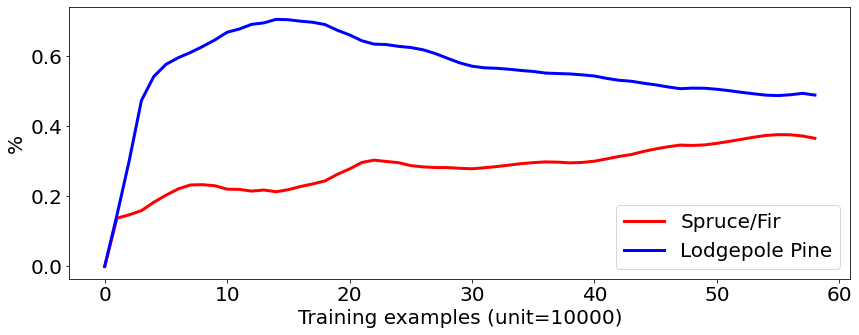

In [4]:
proportions = np.array(proportions)
plt.plot(proportions[:,0],'r-', lw = 3, label='Spruce/Fir')
plt.plot(proportions[:,1],'b-', lw = 3, label='Lodgepole Pine')
#plt.ylim(0.0,0.8)
plt.xlabel('Training examples (unit=10000)')
plt.ylabel('%')
plt.legend(loc='lower right', numpoints= 1)
plt.show()


- In the previous figure, you can notice how the percentage of examples change as we progress streaming the data in the existing order. A shuffle is really necessary, in this case, if we want a stochastic online algorithm to learn correctly from data.
- This dataset has some kind of ordering, maybe a geographic one, that should be corrected by shuffling the data or we will risk overestimating or underestimating certain classes with respect to others.
- As we are zipping the rows in-memory and shuffling them without much disk usage, we can quickly obtain a new working file. 



In [5]:
def ram_shuffle(filename_in, filename_out, header=True):
    with open(filename_in, 'rb') as f:
        zlines = [zlib.compress(line, 9) for line in f]
        if header:
            first_row = zlines.pop(0)
    shuffle(zlines)
    with open(filename_out, 'wb') as f:
        if header:
            f.write(zlib.decompress(first_row))
        for zline in zlines:
            f.write(zlib.decompress(zline))

In [6]:
ram_shuffle(filename_in=source, filename_out = sourceFolder + 'shuffled_covtype.data', header=False)

# Training


- The following code will train SGDClassifier. Please note that **SGD**. 
- We use **log loss** (equivalent to a logistic regression) so that it leverages our previous knowledge of the classes present in the dataset.
- The dataset has ~500k instances and it may prove a bit long to stream and model with SGD. 
- If we limit ourselves to 250k we can expect the results in 15-20 minutes.
- For validation purposes, we define a cold start at 200.000 observed cases. At every ten instances, one will be left out of training and used for validation. This schema allows reproducibility even if we are going to pass over the data multiple times; at every pass, the same instances will be left out as an out-of-sample test, allowing the creation of a validation curve to test the effect of multiple passes over the same data.
- The holdout schema is accompanied by a progressive validation, too. So each case after the cold start is evaluated before being fed to the training. Although progressive validation provides an interesting feedback, such an approach will work only for the first pass; in fact after the initial pass, all the observations (but the ones in the holdout schema) will become in-sample instances. In our example, we are going to make only one pass.



In [58]:
sourceShuffledDataset = '../DATASETS/LARGE_DATASETS/covtype/shuffled_covtype.data'
SEP = ','
forest_type = [t + 1 for t in range(7)]
SGD = SGDClassifier(loss='log', penalty=None, random_state=1,average=True)

accuracy = 0
holdout_count = 0
prog_accuracy = 0
prog_count = 0
cold_start = 200000
k_holdout = 10

with open(sourceShuffledDataset, 'r') as R:
    iterator = csv.reader(R, delimiter=SEP)
    for n, row in enumerate(iterator):
        # Reducing the running time of the experiment
        NoOfInstances = 250000
        if n > NoOfInstances: 
            break
        # DATA PROCESSING
        response = np.array([int(row[-1])]) # The response is the last value
        # This because in python3.x map returns an iterator object?
        a=[*map(float,row[:-1])]
        features = np.array(a).reshape(1,-1)
        #stop
        #features = np.array(map(float,row[:-1])).reshape(1,-1)
        #print(features)
        #stop
        # MACHINE LEARNING
        if (n+1) >= cold_start and (n+1-cold_start) % k_holdout==0:
            if int(SGD.predict(features))==response[0]:
                accuracy += 1
            holdout_count += 1
            if (n+1-cold_start) % 25000 == 0 and (n+1) > cold_start:
                print('%s holdout accuracy: %0.3f' % (time.strftime('%X'), accuracy / float(holdout_count)))
        else:
            # PROGRESSIVE VALIDATION
            if (n+1) >= cold_start:
                if int(SGD.predict(features))==response[0]:
                    prog_accuracy += 1
                prog_count += 1
                if n % 25000 == 0 and n > cold_start:
                    print('%s progressive accuracy: %0.3f' % (time.strftime('%X'), prog_accuracy / float(prog_count)))
            # LEARNING PHASE            
            SGD.partial_fit(features, response, classes=forest_type)
            
            
print('%s FINAL holdout accuracy: %0.3f' % (time.strftime('%X'), accuracy / ((n+1-cold_start) / float(k_holdout))))
print('%s FINAL progressive accuracy: %0.3f' % (time.strftime('%X'), prog_accuracy / float(prog_count)))


15:34:05 holdout accuracy: 0.626
15:34:05 progressive accuracy: 0.616
15:35:28 holdout accuracy: 0.619
15:35:28 progressive accuracy: 0.617
15:35:28 FINAL holdout accuracy: 0.619
15:35:28 FINAL progressive accuracy: 0.617


# References
<hr style="border:2px solid black"> </hr>


- Sjardin, Bastiaan, Luca Massaron, and Alberto Boschetti. Large Scale Machine Learning with Python. Packt Publishing Ltd, 2016.<br>
- https://github.com/packtpublishing/large-scale-machine-learning-with-python 
- [sklearn.linear_model.SGDClassifier¶](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

